<a href="https://colab.research.google.com/github/Mohammed-Hasan-Mustafa/NLP-USING-BERT/blob/main/TextclassificationusingBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP USING BERT ASSIGNMENT /sentiment_train.csv')

In [ ]:
df.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [ ]:
df.describe()

,label
count,5668.000000
mean,0.565279
std,0.495764
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:

lens=[len(i.split()) for i in df.sentence]

(array([2113., 1092.,  912.,  692.,  276.,  253.,  155.,   29.,  142.,
           4.]),
 array([ 3. ,  6.7, 10.4, 14.1, 17.8, 21.5, 25.2, 28.9, 32.6, 36.3, 40. ]),
 <BarContainer object of 10 artists>)

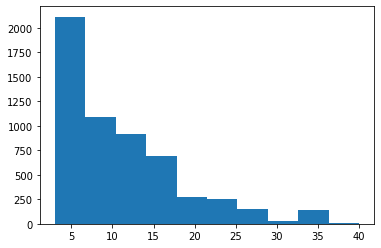

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.8 MB/s eta 0:00:00


In [ ]:
#for pytorch
import torch
import torch.nn as nn
device = torch.device("cuda")

#for BERT
import transformers
from transformers import AutoModel, BertTokenizerFast

In [ ]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['sentence'], df['label'],
                                                                    random_state=2021,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

(array([1504.,  701.,  572.,  521.,  164.,  215.,  117.,   63.,  104.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

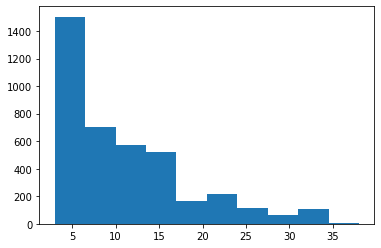

In [ ]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [ ]:
pad_len = 17

In [ ]:
# tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze the BERT architecture

for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)

# push the model to GPU
model = model.to(device)

In [ ]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)  # learning rate

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))

class weights are [1.14985507 0.88470116] for [0 1]


In [ ]:
#count of both the categories of training labels
pd.value_counts(train_labels)

1    2242
0    1725
Name: label, dtype: int64

In [ ]:
#wrap class weights in tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push weights to GPU
weights = weights.to(device)

# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:

# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6924890539338512
Validation Loss: 0.6834435207503182

 Epoch 2 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6857488837934309
Validation Loss: 0.6746872918946403

 Epoch 3 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6797004034442287
Validation Loss: 0.6698914340564183

 Epoch 4 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6750077364906188
Validation Loss: 0.6636713530336108

 Epoch 5 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6724878453439281
Validation Loss: 0.6595127497400556

 Epoch 6 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6695151463631661
Validation Loss: 0.6556929903370994

 Epoch 7 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6665062154493024
Validation Loss: 0.6524529584816524

 Epoch 8 / 10
  Batch    50  of     62.

Evaluating...

Training Loss: 0.6629325728262624
Validation Loss: 0.6

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.55      0.91      0.69       370
           1       0.86      0.44      0.58       481

    accuracy                           0.64       851
   macro avg       0.71      0.67      0.63       851
weighted avg       0.73      0.64      0.63       851

